In [44]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [45]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import OneSidedSelection
from sklearn.preprocessing import Binarizer

In [46]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [47]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [48]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [49]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [33]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [100, 500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1],    ###
               'max_depth' : [8, 10],     ###
               'max_leaves' : [63, 255, 102],
               'objective':['binary:logistic'],
               'subsample' : [0.5, 1.0],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'tree_method' : ['hist'],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=121)
    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=cv, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [50]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]

In [51]:
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]

#### 데이터 분포

In [10]:
neg, pos = np.bincount(df_good['target'])
total = neg + pos
print(f'[데이터] \n전체: {total}개 \n부실 기업: {pos}개 (전체의 {round((100*pos/total),2)}%)')

[데이터] 
전체: 75474개 
부실 기업: 7972개 (전체의 10.56%)


In [11]:
neg, pos = np.bincount(df_bad['target'])
total = neg + pos
print(f'[데이터] \n전체: {total}개 \n부실 기업: {pos}개 (전체의 {round((100*pos/total),2)}%)')

[데이터] 
전체: 34974개 
부실 기업: 2974개 (전체의 8.5%)


#### Modeling

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'max_leaves': 255, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'subsample': 1.0, 'tree_method': 'hist', 'verbosity': 0}
학습 데이터 정확도 :  0.6754600470374003

예측 데이터 정확도
accuracy score : 0.908
precision score : 0.544
recall score : 0.819
f1 score : 0.654
roc score : 0.869
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.88175    0.47017 0.94417   0.62774    0.90927
0.30000   0.89440    0.50000 0.90778   0.64483    0.90030
0.40000   0.90282    0.52425 0.86136   0.65179    0.88453
0.50000   0.90845    0.54417 0.81932   0.65398    0.86915
0.60000   0.91342    0.56610 0.77102   0.65286    0.85062
0.70000   0.91679    0.58980 0.69636   0.63867    0.81959
0.80000   0.91832    0.61759 0.59473   0.60594    0.77563
0.90000   0.91898    0.6942

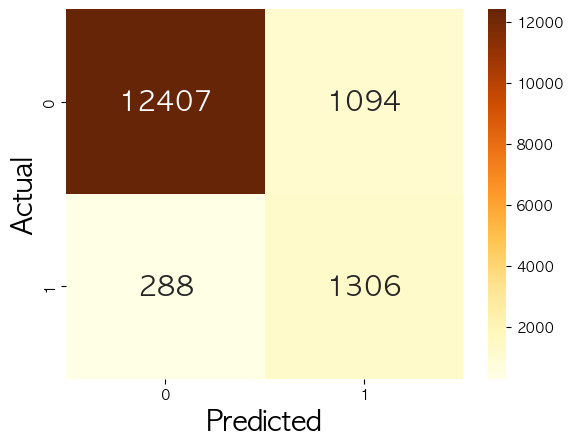

In [28]:
XGB(rfe_good)

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'max_leaves': 255, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'subsample': 0.5, 'tree_method': 'hist', 'verbosity': 0}
학습 데이터 정확도 :  0.5823724421953963

예측 데이터 정확도
accuracy score : 0.881
precision score : 0.406
recall score : 0.850
f1 score : 0.550
roc score : 0.867
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.82988    0.32971 0.96807   0.49189    0.89255
0.30000   0.85361    0.36170 0.94286   0.52283    0.89408
0.40000   0.87162    0.39030 0.90588   0.54555    0.88716
0.50000   0.88149    0.40610 0.85042   0.54970    0.86740
0.60000   0.89521    0.43551 0.78319   0.55976    0.84441
0.70000   0.90608    0.46548 0.70252   0.55995    0.81376
0.80000   0.91823    0.51724 0.57983   0.54675    0.76476
0.90000   0.92680    0.636

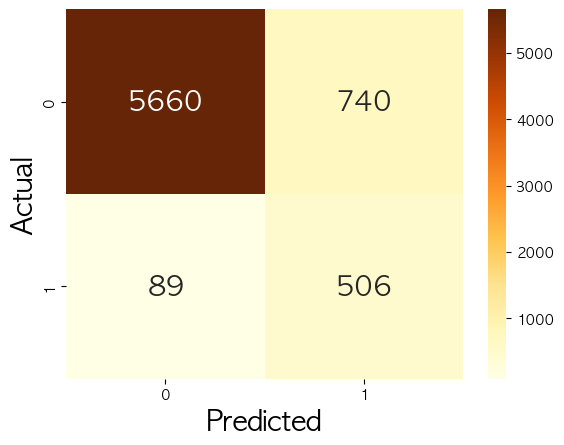

In [29]:
XGB(sfm_rf_bad)

____

In [58]:
def XGB_good(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.05],
               'n_estimators' : [500],
               'min_child_weight' : [5],
               'gamma' : [0.1],
               'max_depth' : [10],
               'max_leaves' : [255],
               'objective':['binary:logistic'],
               'subsample' : [1.0],
               'colsample_bytree' : [0.6],
               'colsample_bylevel' : [0.8],
               'random_state' : [121],
               'tree_method' : ['exact'],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=121)
    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=cv, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

In [59]:
def XGB_bad(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01],
               'n_estimators' : [500],
               'min_child_weight' : [3],
               'gamma' : [0.1],
               'max_depth' : [10],
               'max_leaves' : [255],
               'objective':['binary:logistic'],
               'subsample' : [0.5],
               'colsample_bytree' : [0.8],
               'colsample_bylevel' : [0.8],
               'random_state' : [121],
               'tree_method' : ['exact'],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=121)
    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=cv, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'max_leaves': 255, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'subsample': 1.0, 'tree_method': 'exact', 'verbosity': 0}
학습 데이터 정확도 :  0.6754195333567802

예측 데이터 정확도
accuracy score : 0.908
precision score : 0.543
recall score : 0.829
f1 score : 0.656
roc score : 0.873
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.87426    0.45422 0.94605   0.61376    0.90592
0.30000   0.89162    0.49291 0.91593   0.64091    0.90234
0.40000   0.90142    0.51975 0.87516   0.65217    0.88984
0.50000   0.90818    0.54269 0.82936   0.65608    0.87342
0.60000   0.91481    0.57156 0.77164   0.65670    0.85168
0.70000   0.92064    0.60808 0.69887   0.65032    0.82284
0.80000   0.92097    0.64011 0.57465   0.60562    0.76825
0.90000   0.91852    0.706

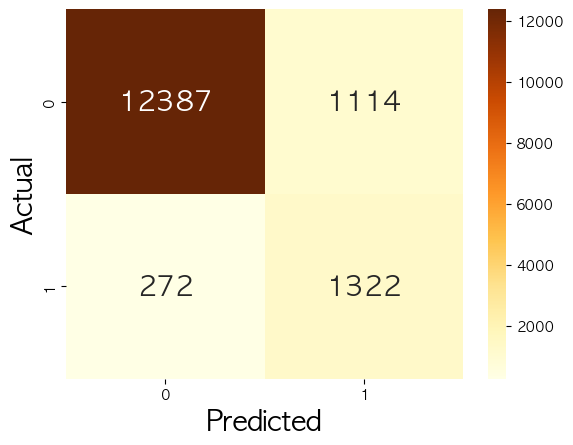

In [60]:
XGB_good(rfe_good)

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'max_leaves': 255, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'subsample': 0.5, 'tree_method': 'exact', 'verbosity': 0}
학습 데이터 정확도 :  0.5816061077430448

예측 데이터 정확도
accuracy score : 0.884
precision score : 0.412
recall score : 0.855
f1 score : 0.556
roc score : 0.871
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.82459    0.32327 0.97143   0.48510    0.89118
0.30000   0.85004    0.35615 0.94454   0.51726    0.89289
0.40000   0.86934    0.38615 0.90924   0.54208    0.88743
0.50000   0.88392    0.41215 0.85546   0.55628    0.87101
0.60000   0.89464    0.43426 0.78824   0.56000    0.84638
0.70000   0.90536    0.46282 0.70084   0.55749    0.81261
0.80000   0.91808    0.51642 0.58151   0.54704    0.76544
0.90000   0.92623    0.63

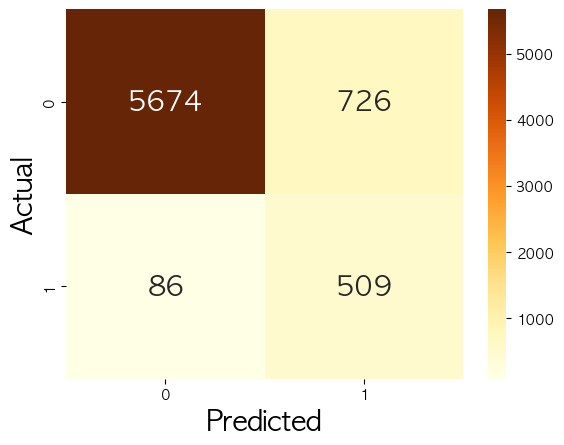

In [61]:
XGB_bad(sfm_rf_bad)